# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1085: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1085: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


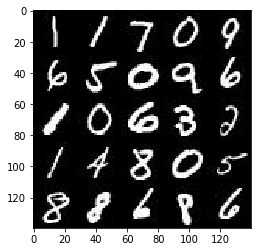

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

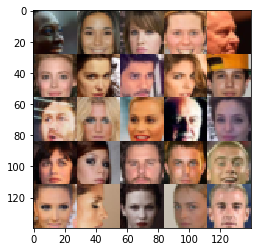

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


TensorFlow Version: 1.4.1
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(dtype=tf.float32, shape=(None, image_width, image_height, image_channels), name="inputs_real")
    input_z = tf.placeholder(dtype=tf.float32, shape=(None, z_dim), name="inputs_z")
    learning_rate = tf.placeholder(dtype=tf.float32, shape=(None), name="learning_rate")
    return inputs_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.11
    with tf.variable_scope('discriminator', reuse=reuse):
        h1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        lr = tf.maximum(alpha * h1, h1)
        # ?x14x14x64
        
        h2 = tf.layers.conv2d(lr, 128, 5, strides=2, padding='same')
        bn1 = tf.layers.batch_normalization(h2, training=True)
        lr2 = tf.maximum(alpha * bn1, bn1)
        # ?x7x7x128
        
        h3 = tf.layers.conv2d(lr2, 256, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(h3, training=True)
        lr3 = tf.maximum(alpha * bn2, bn2)
        # ?x4x4x256
        
        h4 = tf.layers.conv2d(lr3, 512, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(h4, training=True)
        lr4 = tf.maximum(alpha * bn3, bn3)
        # ?x2x2x512
        
        flatten = tf.reshape(lr4, (-1, 2*2*512))
        logits = tf.layers.dense(flatten, 1)
        out = tf.sigmoid(logits)
    
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.09
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse= not is_train):
        h1 = tf.layers.dense(z, 7*7*1024)
        h1_n = tf.nn.l2_normalize(h1, dim=-1, epsilon=1e-12)
        h1_r = tf.reshape(h1_n, (-1, 7, 7, 1024))
        bn1 = tf.layers.batch_normalization(h1_r, training=is_train)
        lr1 = tf.maximum(alpha * bn1, bn1)
        # ?x7x7x1024
        
        h2 = tf.layers.conv2d_transpose(lr1, 512, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(h2, training=is_train)
        lr2 = tf.maximum(alpha * bn2, bn2)
        #drop = tf.nn.dropout(lr2, 0.5)
        # ?x14x14x256
        
        h3 = tf.layers.conv2d_transpose(lr2, 256, 5, strides=1, padding='same')
        bn3 = tf.layers.batch_normalization(h3, training=is_train)
        lr3 = tf.maximum(alpha * bn3, bn3)
        drop2 = tf.nn.dropout(lr3, 0.7)
        # ?x14x14x128        
        
        
        h4 = tf.layers.conv2d_transpose(drop2, 128, 5, strides=1, padding='same')
        bn4 = tf.layers.batch_normalization(h4, training=is_train)
        lr4 = tf.maximum(alpha * bn4, bn4)
        #drop = tf.nn.dropout(lr4, 0.6)
        # ?x14x14x128
        
        logits = tf.layers.conv2d_transpose(lr4, out_channel_dim, 5, strides=2, padding='same')
        #drop3 = tf.nn.dropout(logits, 0.6)
        # ?x28x28x64
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smoothing = 0.9
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * smoothing))
    
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    trainable_vars = tf.trainable_variables()
    discriminator_vars = [var for var in trainable_vars if var.name.startswith('discriminator')]
    generator_vars = [var for var in trainable_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.GradientDescentOptimizer(learning_rate).minimize(d_loss, var_list=discriminator_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=generator_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    img_width, img_height, img_channels = data_shape[1], data_shape[2], data_shape[3]
    inputs_real, input_z, lr = model_inputs(img_width, img_height, img_channels, z_dim)
    d_loss, g_loss = model_loss(inputs_real, input_z, img_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    steps = 0
    print_every = 50
    show_every =  100
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *= 2.0
                
                batch_z = np.random.normal(-1, 1, size=(batch_size,z_dim))
                
                _ = sess.run(d_opt, feed_dict={inputs_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, inputs_real: batch_images, lr: learning_rate})
                
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, inputs_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    _ = sess.run(g_opt, feed_dict={input_z: batch_z, inputs_real: batch_images, lr: learning_rate})
                    _ = sess.run(g_opt, feed_dict={input_z: batch_z, inputs_real: batch_images, lr: learning_rate})
                    _ = sess.run(g_opt, feed_dict={input_z: batch_z, inputs_real: batch_images, lr: learning_rate})
                if steps % show_every == 0:
                    show_generator_output(sess, 10, input_z, img_channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 2.1744... Generator Loss: 7.4033
Epoch 1/2... Discriminator Loss: 0.5645... Generator Loss: 5.2656


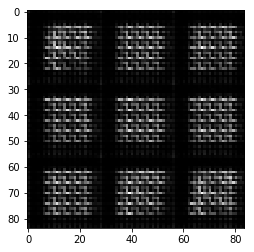

Epoch 1/2... Discriminator Loss: 0.6972... Generator Loss: 1.2826
Epoch 1/2... Discriminator Loss: 2.0899... Generator Loss: 0.1932


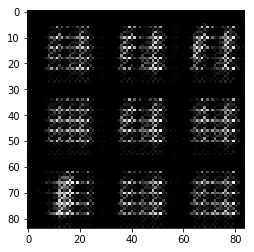

Epoch 1/2... Discriminator Loss: 0.4774... Generator Loss: 5.4042
Epoch 1/2... Discriminator Loss: 0.3770... Generator Loss: 3.4682


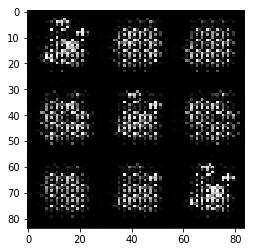

Epoch 1/2... Discriminator Loss: 0.4485... Generator Loss: 2.4575
Epoch 1/2... Discriminator Loss: 0.6134... Generator Loss: 2.4894


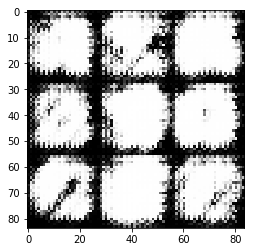

Epoch 1/2... Discriminator Loss: 0.8845... Generator Loss: 1.6372
Epoch 1/2... Discriminator Loss: 0.5077... Generator Loss: 3.0090


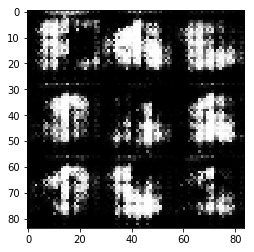

Epoch 1/2... Discriminator Loss: 0.4874... Generator Loss: 3.0658
Epoch 1/2... Discriminator Loss: 0.5440... Generator Loss: 2.6094


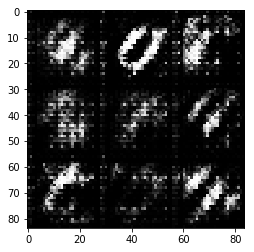

Epoch 1/2... Discriminator Loss: 0.4729... Generator Loss: 2.4597
Epoch 1/2... Discriminator Loss: 0.3829... Generator Loss: 4.4969


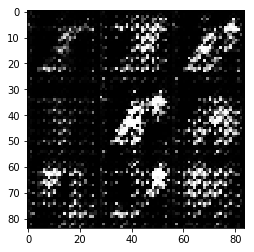

Epoch 1/2... Discriminator Loss: 0.4205... Generator Loss: 3.2224
Epoch 1/2... Discriminator Loss: 0.4007... Generator Loss: 3.1889


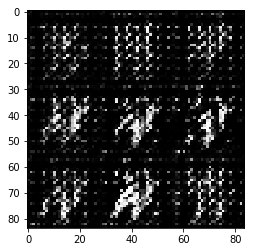

Epoch 1/2... Discriminator Loss: 0.4045... Generator Loss: 2.5589
Epoch 1/2... Discriminator Loss: 0.3470... Generator Loss: 6.2694


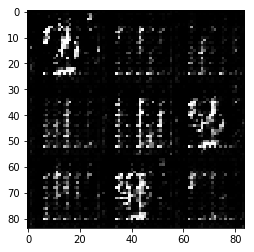

Epoch 1/2... Discriminator Loss: 0.4035... Generator Loss: 3.8633
Epoch 1/2... Discriminator Loss: 0.4167... Generator Loss: 3.5350


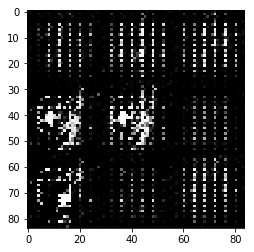

Epoch 1/2... Discriminator Loss: 0.4075... Generator Loss: 2.5867
Epoch 1/2... Discriminator Loss: 0.4291... Generator Loss: 3.2897


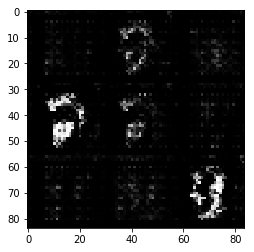

Epoch 1/2... Discriminator Loss: 0.4404... Generator Loss: 2.6837
Epoch 1/2... Discriminator Loss: 0.3641... Generator Loss: 3.9032


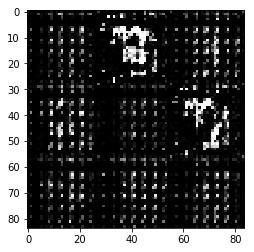

Epoch 1/2... Discriminator Loss: 0.3576... Generator Loss: 3.9963
Epoch 1/2... Discriminator Loss: 0.3915... Generator Loss: 3.4112


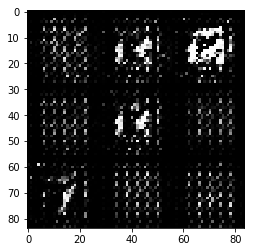

Epoch 1/2... Discriminator Loss: 0.3727... Generator Loss: 4.2466
Epoch 1/2... Discriminator Loss: 0.3442... Generator Loss: 5.0815


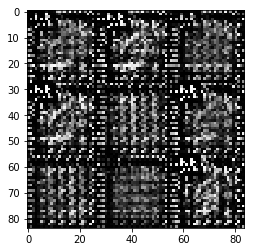

Epoch 1/2... Discriminator Loss: 0.7785... Generator Loss: 6.4855
Epoch 1/2... Discriminator Loss: 0.3728... Generator Loss: 3.3498


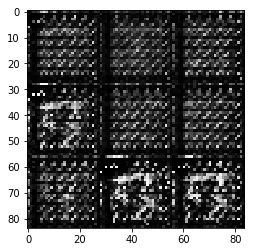

Epoch 1/2... Discriminator Loss: 0.3605... Generator Loss: 3.6602
Epoch 1/2... Discriminator Loss: 0.3621... Generator Loss: 4.5579


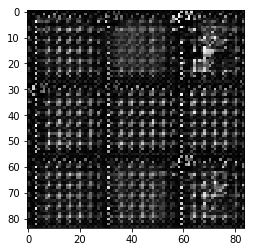

Epoch 1/2... Discriminator Loss: 0.3454... Generator Loss: 4.7574
Epoch 1/2... Discriminator Loss: 0.3559... Generator Loss: 3.8972


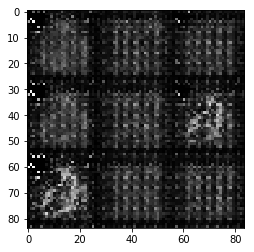

Epoch 1/2... Discriminator Loss: 0.4009... Generator Loss: 2.6497
Epoch 1/2... Discriminator Loss: 0.3482... Generator Loss: 4.3510


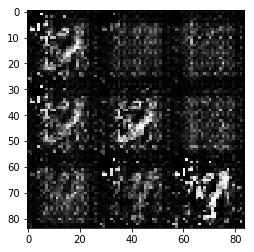

Epoch 1/2... Discriminator Loss: 0.3530... Generator Loss: 4.2781
Epoch 2/2... Discriminator Loss: 0.3412... Generator Loss: 4.8409


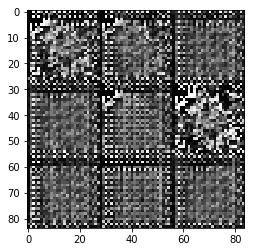

Epoch 2/2... Discriminator Loss: 0.3400... Generator Loss: 4.8374
Epoch 2/2... Discriminator Loss: 0.3431... Generator Loss: 4.5392


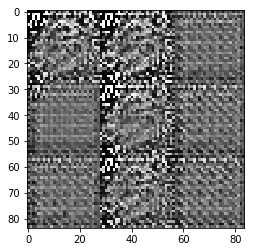

Epoch 2/2... Discriminator Loss: 0.3365... Generator Loss: 5.2484
Epoch 2/2... Discriminator Loss: 0.3371... Generator Loss: 5.0171


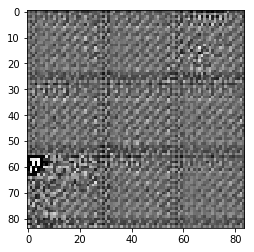

Epoch 2/2... Discriminator Loss: 0.3357... Generator Loss: 5.6237
Epoch 2/2... Discriminator Loss: 0.3355... Generator Loss: 5.3689


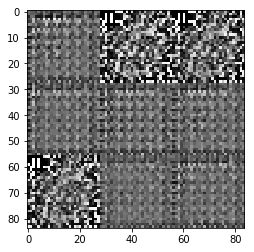

Epoch 2/2... Discriminator Loss: 0.3426... Generator Loss: 5.0913
Epoch 2/2... Discriminator Loss: 0.3445... Generator Loss: 5.0741


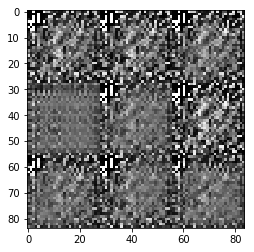

Epoch 2/2... Discriminator Loss: 0.3506... Generator Loss: 3.8180
Epoch 2/2... Discriminator Loss: 0.3489... Generator Loss: 4.0199


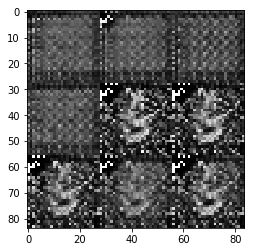

Epoch 2/2... Discriminator Loss: 0.3436... Generator Loss: 4.6655
Epoch 2/2... Discriminator Loss: 0.3428... Generator Loss: 4.5384


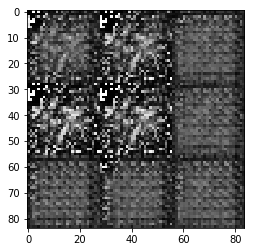

Epoch 2/2... Discriminator Loss: 0.3400... Generator Loss: 4.5930
Epoch 2/2... Discriminator Loss: 0.3419... Generator Loss: 4.5373


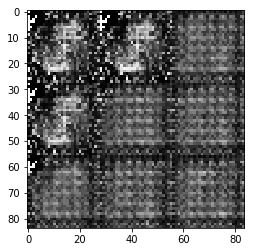

Epoch 2/2... Discriminator Loss: 0.3302... Generator Loss: 6.0253
Epoch 2/2... Discriminator Loss: 0.3330... Generator Loss: 5.8278


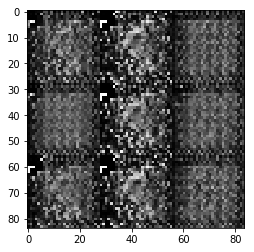

Epoch 2/2... Discriminator Loss: 0.3321... Generator Loss: 6.0984
Epoch 2/2... Discriminator Loss: 0.3323... Generator Loss: 5.6160


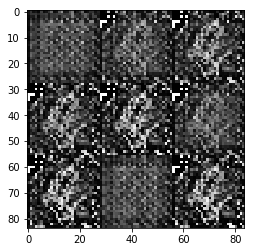

Epoch 2/2... Discriminator Loss: 0.3411... Generator Loss: 4.2655
Epoch 2/2... Discriminator Loss: 0.3334... Generator Loss: 5.2551


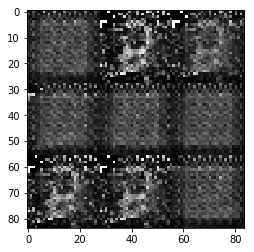

Epoch 2/2... Discriminator Loss: 0.3303... Generator Loss: 6.4080
Epoch 2/2... Discriminator Loss: 0.3317... Generator Loss: 6.1534


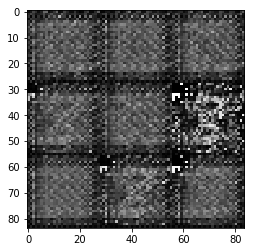

Epoch 2/2... Discriminator Loss: 0.3344... Generator Loss: 5.4381
Epoch 2/2... Discriminator Loss: 0.3311... Generator Loss: 5.4352


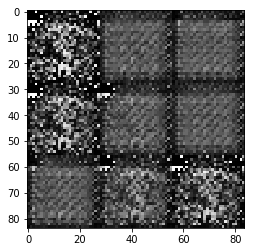

Epoch 2/2... Discriminator Loss: 0.3287... Generator Loss: 6.7743
Epoch 2/2... Discriminator Loss: 0.3300... Generator Loss: 6.8391


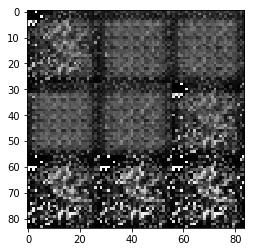

Epoch 2/2... Discriminator Loss: 0.3361... Generator Loss: 5.2482
Epoch 2/2... Discriminator Loss: 0.3333... Generator Loss: 5.1202


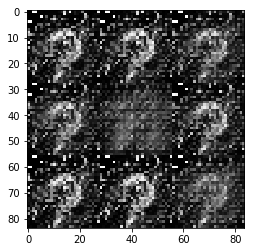

Epoch 2/2... Discriminator Loss: 0.3333... Generator Loss: 5.4938
Epoch 2/2... Discriminator Loss: 0.3350... Generator Loss: 5.2120


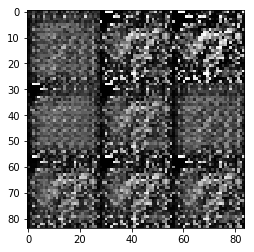

Epoch 2/2... Discriminator Loss: 0.3297... Generator Loss: 6.7062
Epoch 2/2... Discriminator Loss: 0.3298... Generator Loss: 6.2385


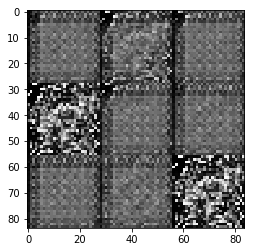

Epoch 2/2... Discriminator Loss: 0.3292... Generator Loss: 6.2096
Epoch 2/2... Discriminator Loss: 0.3310... Generator Loss: 6.1225


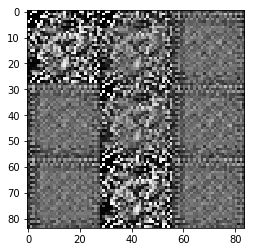

Epoch 2/2... Discriminator Loss: 0.3321... Generator Loss: 6.3463


In [ ]:
batch_size = 32 #best at 150 so far - tested: 50 32(-)
z_dim = 400 #best at 100 so far - tested 150(F) 200(?) 400(?)
learning_rate = 0.002
beta1 = 0.3

#top hp's
#batch_size = 50 #best at 150 so far - tested: 50 32(?)
#z_dim = 100 #best at 100 so far - tested 150(F) 250(?)
#learning_rate = 0.002 #best at 0.002 - tested: 0.0002(?)
#beta1 = 0.4 #best at 0.4

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)


### CelebA

Run your GANs on CelebA. It will take around 20 minutes on the average GPU to run one epoch. You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 4.2136... Generator Loss: 0.0689
Epoch 1/1... Discriminator Loss: 3.2234... Generator Loss: 0.2063


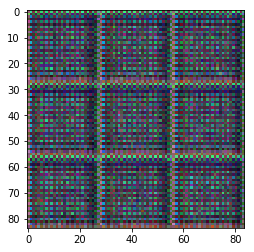

Epoch 1/1... Discriminator Loss: 2.9892... Generator Loss: 0.3080
Epoch 1/1... Discriminator Loss: 2.2609... Generator Loss: 0.4791


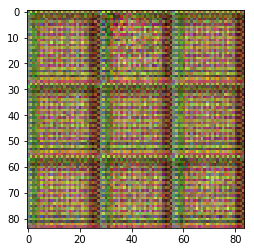

Epoch 1/1... Discriminator Loss: 2.0413... Generator Loss: 0.5191
Epoch 1/1... Discriminator Loss: 1.9556... Generator Loss: 0.5916


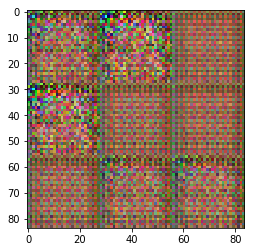

Epoch 1/1... Discriminator Loss: 1.8298... Generator Loss: 0.6057
Epoch 1/1... Discriminator Loss: 1.7134... Generator Loss: 0.6591


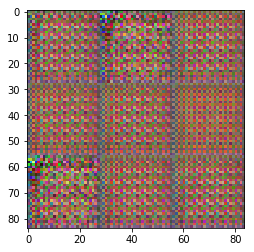

Epoch 1/1... Discriminator Loss: 1.5745... Generator Loss: 0.7792
Epoch 1/1... Discriminator Loss: 1.3211... Generator Loss: 0.9225


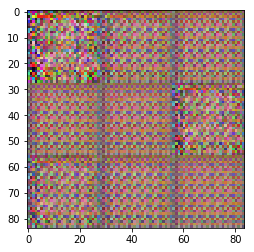

Epoch 1/1... Discriminator Loss: 1.0044... Generator Loss: 1.1949
Epoch 1/1... Discriminator Loss: 1.0140... Generator Loss: 1.3741


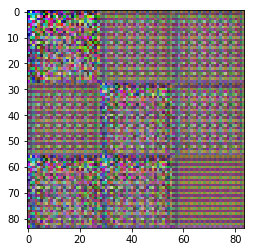

Epoch 1/1... Discriminator Loss: 1.3073... Generator Loss: 0.9011
Epoch 1/1... Discriminator Loss: 1.2238... Generator Loss: 0.9562


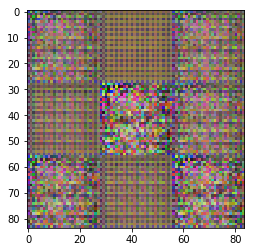

Epoch 1/1... Discriminator Loss: 0.9641... Generator Loss: 1.2102
Epoch 1/1... Discriminator Loss: 0.8767... Generator Loss: 1.2872


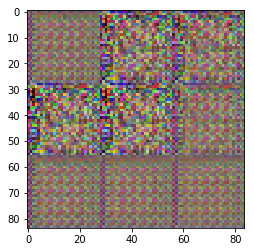

Epoch 1/1... Discriminator Loss: 0.9130... Generator Loss: 1.5046
Epoch 1/1... Discriminator Loss: 0.5749... Generator Loss: 1.9352


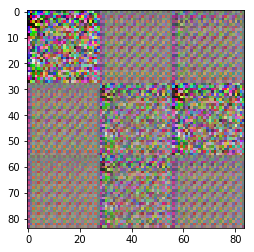

Epoch 1/1... Discriminator Loss: 0.6241... Generator Loss: 1.5619
Epoch 1/1... Discriminator Loss: 0.7241... Generator Loss: 1.4734


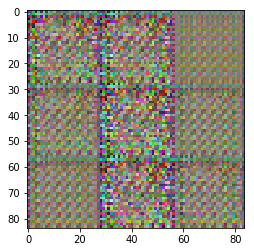

Epoch 1/1... Discriminator Loss: 0.9164... Generator Loss: 1.3262
Epoch 1/1... Discriminator Loss: 0.7993... Generator Loss: 1.4050


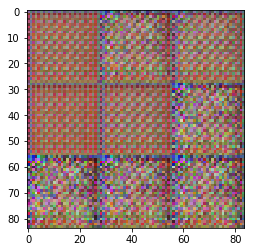

Epoch 1/1... Discriminator Loss: 0.7092... Generator Loss: 1.6000
Epoch 1/1... Discriminator Loss: 0.7156... Generator Loss: 1.6172


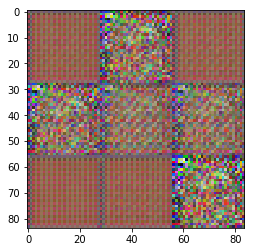

Epoch 1/1... Discriminator Loss: 0.6270... Generator Loss: 1.7221
Epoch 1/1... Discriminator Loss: 0.6318... Generator Loss: 1.8024


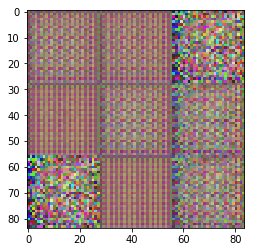

Epoch 1/1... Discriminator Loss: 0.5871... Generator Loss: 2.0171


In [19]:
batch_size = 150
z_dim = 150
learning_rate = 0.00025
beta1 = 0.6

# batch_size = 150 #best at 150 so far - tested: 100(-) 32(-)
# z_dim = 150 #best at 150 so far - tested 200(-) 100(?)
# learning_rate = 0.00025
# beta1 = 0.6

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.